# **Spaceship Titanic**

## **Librerías**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.max_columns = False

In [3]:
from datetime import datetime, timedelta
import winsound

In [4]:
import sys

In [5]:
sys.path.append('C:/Users/jmart/OneDrive/Documentos/Proyectos/Proyectos_Web/Utils')

In [223]:
from sklearn.model_selection import train_test_split

In [212]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

## **Datos**

In [248]:
train_df = pd.read_csv('./Datos/train.csv')

In [249]:
train_df.sample()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
2044,2189_01,Earth,NaN,G/354/P,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,628.0,0.0,Nelly Cruzaley,False


In [250]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [251]:
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


### **Limpieza y Preparación de Datos**

In [252]:
# Planeta natal
train_df['HomePlanet'].fillna('Unknown', inplace=True)
train_df.value_counts(['HomePlanet'])

HomePlanet
Earth         4602
Europa        2131
Mars          1759
Unknown        201
dtype: int64

In [253]:
# Sueño criogenico
train_df['CryoSleep'].fillna('Unknown', inplace=True)
train_df.value_counts(['CryoSleep'])

CryoSleep
False        5439
True         3037
Unknown       217
dtype: int64

In [254]:
def calc_detail_cabin(x, position):
	# Divides la cadena en subcadenas utilizando '/' como separador y devuelve el primer elemento
	try:
		return x.split('/')[position]        
	# Si ocurre algún error al intentar dividir la cadena, se devuelve la cadena original
	except:
		return x

In [255]:
# Información de la cabina
train_df['Cabin'].fillna('Unknown', inplace=True)
train_df['Cabin_Type'] = train_df['Cabin'].apply(lambda x: calc_detail_cabin(x, 0))
train_df['Cabin_Type_2'] = train_df['Cabin'].apply(lambda x: calc_detail_cabin(x, 2))

In [256]:
train_df.value_counts(['Cabin_Type'])

Cabin_Type
F             2794
G             2559
E              876
B              779
C              747
D              478
A              256
Unknown        199
T                5
dtype: int64

In [257]:
train_df.value_counts(['Cabin_Type_2'])

Cabin_Type_2
S               4288
P               4206
Unknown          199
dtype: int64

In [258]:
# Destino
train_df['Destination'].fillna('Unknown', inplace=True)
train_df.value_counts(['Destination'])

Destination  
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Unknown           182
dtype: int64

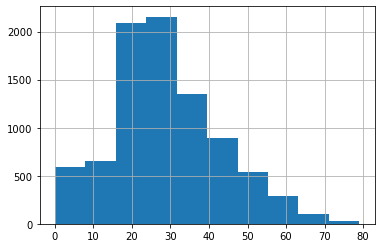

In [259]:
#Edad
train_df['Age'].fillna(round(train_df['Age'].mean()), inplace=True)
train_df['Age'].hist()
plt.show()

In [260]:
# VIP
train_df['VIP'].fillna('Unknown', inplace=True)
train_df.value_counts(['VIP'])

VIP    
False      8291
Unknown     203
True        199
dtype: int64

In [261]:
# Variables numéricas $$
train_df['RoomService'].fillna(0, inplace=True)
train_df['FoodCourt'].fillna(0, inplace=True)
train_df['ShoppingMall'].fillna(0, inplace=True)
train_df['Spa'].fillna(0, inplace=True)
train_df['VRDeck'].fillna(0, inplace=True)

In [262]:
# Eliminamos el nombre
train_df.drop('Name', axis= 1, inplace=True)

In [263]:
train_df['Transported'].replace([False, True], [0, 1], inplace=True)

### **Preparando los datos para el modelo**

In [264]:
train_df['CryoSleep'].replace([False, True, 'Unknown'], [0, 1, 0], inplace=True)
train_df['VIP'].replace([False, True, 'Unknown'], [0, 1, 0], inplace=True)

In [265]:
home_planet_dum = pd.get_dummies(train_df['HomePlanet'])
destination_dum = pd.get_dummies(train_df['Destination'])
cabin_I_dum = pd.get_dummies(train_df['Cabin_Type'])
cabin_II_dum = pd.get_dummies(train_df['Cabin_Type_2'])

In [266]:
X = train_df.drop(
    ['PassengerId', 'HomePlanet', 'Cabin', 'Destination', 'Cabin_Type', 'Cabin_Type_2'], 
    axis=1
)

In [267]:
X = pd.merge(X.reset_index(), home_planet_dum.reset_index(), how='left', left_on='index', right_on='index')
X = pd.merge(X, destination_dum.reset_index(), how='left', left_on='index', right_on='index')
X = pd.merge(X, cabin_I_dum.reset_index(), how='left', left_on='index', right_on='index')
X = pd.merge(X, cabin_II_dum.reset_index(), how='left', left_on='index', right_on='index')

C:\Users\jmart\AppData\Local\Temp\ipykernel_17144\1860298275.py:4: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unknown_x'} in the result is deprecated and will raise a MergeError in a future version.
  X = pd.merge(X, cabin_II_dum.reset_index(), how='left', left_on='index', right_on='index')


In [268]:
X.drop(['index', 'Unknown_x', 'Unknown_y', 'Unknown_x', 'Unknown_y', 'Transported'], axis=1, inplace=True)

## **Modelo**

In [270]:
train_df['Transported'].value_counts()

1    4378
0    4315
Name: Transported, dtype: int64

In [271]:
y = train_df['Transported']

In [272]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13, train_size=0.8)

### **1. Random Forest**

In [273]:
random_forest = RandomForestClassifier()

In [274]:
random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [275]:
y_pred = random_forest.predict(X_test)

In [278]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       906
           1       0.78      0.81      0.80       833

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



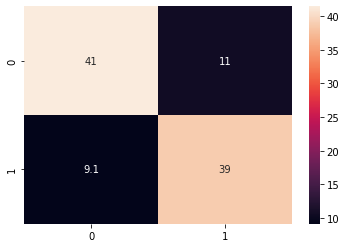

In [277]:
sns.heatmap((confusion_matrix(y_pred, y_test)/len(X_test))*100, annot=True)
plt.show()

In [281]:
feature_importance = random_forest.feature_importances_
feature_names=X.columns
dic_feature_importance = {
                        'feature_importance':feature_importance ,
                        'feature_names':feature_names }
feature_importance_DF= pd.DataFrame(dic_feature_importance).sort_values(by='feature_importance',ascending=False)
feature_importance_DF.head(5)

,feature_importance,feature_names
1,0.175718,Age
6,0.119084,Spa
3,0.115851,RoomService
7,0.110468,VRDeck
4,0.107065,FoodCourt
